# criticism_detection.ipynb

### 1 ###
•	It analysis papers citing another one that has been retracted.
•	It takes papers that triggered the retraction and classify them as highly_critical.
•	Papers published a year before the first highly_critical paper are classified as non_critical.
•	Papers published after the highly_critical papers are classified as critical (they are not used in the analysis later on because they may contain mixed criticism).
•	Date of publication of the papers are taken from the “PMC-ids.csv.gz” file, available through the PMC FTP service:
https://www.ncbi.nlm.nih.gov/pmc/pmctopmid/

### 2 ###
•	It takes all the sentences citing a particular DOI in all the papers disregarding its section. 
•	It shows that clustering algorithms such as PCA and TSNE fail if trying to cluster the sentences from non_critical and high_critical papers just using vader lexicon.

### 3 ###
•	It gets all the sentences in the high_critical papers and a similar number of sentences from the non_critical papers. I finds the words and bigrams used in the high_critical set and are not used in the non_critical set.


In [1]:
%matplotlib inline

In [2]:
import sys
import re
import os
import numpy as np
import pandas as pd
import nltk
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sys.path.insert(0, "./modules")
import words_frec_analysis_get_sentence

# Configuration

In [3]:
data_path = 'data'

ds_name = 'DOI_cited_science_1179052_retracted'

# The paper was retracted based on:
DOI_high_critical = [
    '10.1186/1742-4690-7-63',
    '10.1371/journal.pone.0008519',
    '10.1136/bmj.c1018',
    '10.1186/1742-4690-7-10',
    '10.1371/journal.pone.0008519',
    '10.1186/1743-422X-7-224'
]

analysis_path = os.path.join(data_path, 'analysis')

# In
citing_sections_tsv = os.path.join(analysis_path, '%s_sections.tsv' % ds_name)
pmc_ids_csv = os.path.join(data_path, 'PMC_ids/PMC-ids.csv.gz')

# Setup

In [4]:
# Get Vader data for sentiment analysis
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/deuser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 1 ###

•	It analysis papers citing another one that has been retracted.
•	It takes papers that triggered the retraction and classify them as highly_critical.
•	Papers published a year before the first highly_critical paper are classified as non_critical.
•	Papers published after the highly_critical papers are classified as critical (they are not used in the analysis later on because they may contain mixed criticism).
•	Date of publication of the papers are taken from the “PMC-ids.csv.gz” file, available through the PMC FTP service:
https://www.ncbi.nlm.nih.gov/pmc/pmctopmid/

In [5]:
df = pd.read_csv(
    citing_sections_tsv,
    sep='\t',
    encoding='utf-8'
)

#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']


In [6]:
df_ids = pd.read_csv(pmc_ids_csv, sep=',', encoding='utf-8', low_memory=False)


df_ids_select = df_ids[df_ids['DOI'].isin(df.citing_DOI)]
"""
for element in df.citing_DOI:
    df_ids['DOI'].isin(df.citingDOI)
    df_ids_selection2.append(df_ids[[df_ids["DOI"] == element]])
    #print(element)
"""

df_ids_select.head()

,Journal Title,ISSN,eISSN,Year,Volume,Issue,Page,DOI,PMCID,PMID,Manuscript Id,Release Date
1997127,J Transl Med,NaN,1479-5876,2009,7,NaN,96,10.1186/1479-5876-7-96,PMC2779802,19909538.0,NaN,live
2044695,J Transl Med,NaN,1479-5876,2010,8,NaN,1,10.1186/1479-5876-8-1,PMC2829521,20064266.0,NaN,live
2054642,Retrovirology,NaN,1742-4690,2010,7,NaN,10,10.1186/1742-4690-7-10,PMC2839973,20156349.0,NaN,live
2055756,Retrovirology,NaN,1742-4690,2010,7,NaN,16,10.1186/1742-4690-7-16,PMC2841096,20219088.0,NaN,live
2121671,Retrovirology,NaN,1742-4690,2010,7,NaN,57,10.1186/1742-4690-7-57,PMC2908559,20594299.0,NaN,live


In [7]:
# The paper was retracted based on:
#DOI_high_critical = ['10.1186/1742-4690-7-63', '10.1371/journal.pone.0008519', '10.1136/bmj.c1018', '10.1186/1742-4690-7-10', '10.1371/journal.pone.0008519', '10.1186/1743-422X-7-224']

df_ids_select_info_highCritical = df_ids[df_ids["DOI"].isin(DOI_high_critical)]

df_ids_select_nonCritical = df_ids[((df_ids["Year"] < 2011)) & (df_ids['DOI'].isin(DOI_high_critical) == False)]

df_ids_select_Critical = df_ids[(df_ids["Year"] >= 2011) | (df_ids['DOI'].isin(DOI_high_critical))]


df_highCritical =df[df['citing_DOI'].isin(df_ids_select_info_highCritical['DOI'])]
 
df_nonCritical = df[df['citing_DOI'].isin(df_ids_select_nonCritical['DOI'])]
df_Critical = df[df['citing_DOI'].isin(df_ids_select_Critical['DOI'])]
#df_critical

df_highCritical_text_part1 = df_highCritical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_highCritical_text_part2 = df_highCritical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_highCritical_text_part3 = df_highCritical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_highCritical = pd.concat([df_highCritical_text_part1, df_highCritical_text_part2, df_highCritical_text_part3]).dropna().reset_index(drop=True)
df_full_highCritical['label'] = 'high_critical'

df_part1 = df_nonCritical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_part2 = df_nonCritical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_part3 = df_nonCritical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_nonCritical = pd.concat([df_part1, df_part2, df_part3]).dropna().reset_index(drop=True)
df_full_nonCritical['label'] = 'non_critizising'

df_part1 = df_Critical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_part2 = df_Critical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_part3 = df_Critical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_Critical = pd.concat([df_part1, df_part2, df_part3]).dropna().reset_index(drop=True)
df_full_Critical['label'] = 'critizising'

df_full = pd.concat([df_full_nonCritical, df_full_Critical]).reset_index(drop=True)

In [8]:
print("df_highCritical.shape; ", df_highCritical.shape)
print("df_Critical.shape; ", df_Critical.shape)
print("df_nonCritical.shape: ", df_nonCritical.shape)
print("df_full.shape: ", df_full.shape)

df_highCritical.shape;  (3, 15)
df_Critical.shape;  (21, 15)
df_nonCritical.shape:  (19, 15)
df_full.shape:  (38, 3)


In [9]:
df_highCritical

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_number,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
11,10.1126/science.1179052,False,True,True,True,10.1186/1742-4690-7-10,True,True,True,True,B8,NaN,"['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] co...","['More recently, additional groups of samples ...","['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] (T..."
12,10.1126/science.1179052,False,False,False,True,10.1186/1742-4690-7-63,False,False,False,True,B15,NaN,NaN,NaN,"['More recently, XMRV has also been found, wit..."
31,10.1126/science.1179052,False,True,True,True,10.1186/1743-422X-7-224,True,True,True,True,B3,NaN,['The virus was not detected in any of our stu...,"['In a recent US study, Lombardi et al [<xref ...",['This sequence was obtained by overlapping ex...


### 2 ###

•	It takes all the sentences citing a particular DOI in all the papers disregarding its section. 
•	It shows that clustering algorithms such as PCA and TSNE fail if trying to cluster the sentences from non_critical and high_critical papers just using vader lexicon.

Let's try to use vader_lexicon and pca and tsne to cluster papers criticising and not criticising. 

(<matplotlib.figure.Figure at 0x7f5fc9412a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5fc3f699b0>)

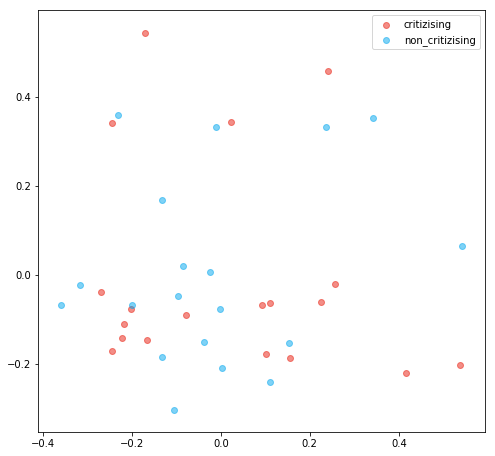

In [10]:
# dimension reduction algorithms can be pretty slow, so let's work with a sample
# try on the whole data set if you want!

# list of colours for making nice plots later
COLOURS = ['#E91D0E', '#00A6EF']


def scatter(x, label, selected_labels, selected_colors):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for selected_label, selected_color in zip(selected_labels, selected_colors):
        x_selected = x[(label == selected_label), :]
        ax.scatter(
            x_selected[:, 0],
            x_selected[:, 1],
            c=selected_color,
            label=selected_label,
            alpha=0.5
        )
    plt.legend()
    
    return f, ax

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_vectors = tfidf_vectorizer.fit_transform(df_full['text'])

pca = PCA(n_components=2)
pca_comp = pca.fit_transform(tfidf_vectors.toarray())
scatter(pca_comp, df_full['label'], ['critizising', 'non_critizising'], COLOURS[:2])

(<matplotlib.figure.Figure at 0x7f5fc3fbf128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f877a6a20>)

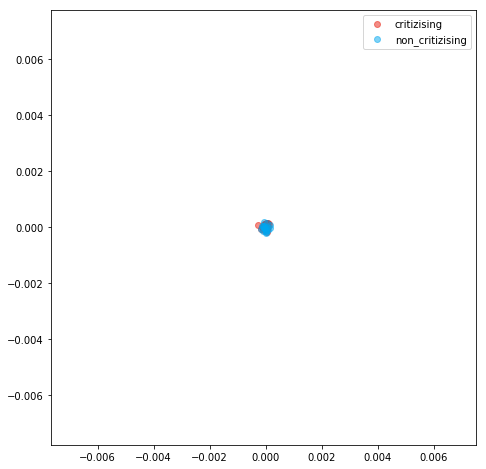

In [11]:
# we have suggested some parameters below, feel free to experiment
tsne = TSNE(perplexity = 800, random_state = 42)

tsne_comp = tsne.fit_transform(tfidf_vectors.toarray())

scatter(tsne_comp, df_full['label'], ['critizising', 'non_critizising'], COLOURS[:2])

As expected it fails PCA and TSNE using vader lexicon fails.

### 3 ###
•	It gets all the sentences in the high_critical papers and a similar number of sentences from the non_critical papers. I finds the words and bigrams used in the high_critical set and are not used in the non_critical set.


Let's analyse the sentences where the paper is cited.

In [12]:
#print("df_highCritical.shape; ", df_highCritical.shape)
#print("df_Critical.shape; ", df_Critical.shape)
#print("df_nonCritical.shape: ", df_nonCritical.shape)
#print("df_full.shape: ", df_full.shape)

#file_df = '/project/elife/data/analysis/df_science1179052_retracted.csv'

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
#df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])
#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']

df_full_highCritical_sample = df_full_highCritical # All the papers the retraction is based on
#df_full_highCritical_sample = df_full_Critical.sample(4, random_state = 1)

sentences_highCritical = df_full_highCritical_sample.text.dropna()
frequent_words_highCritical = words_frec_analysis_get_sentence.analysis_nolimit(sentences_highCritical)

# I get a similar number of nonCritical text paragraphs:
df_full_nonCritical_sample = df_full_nonCritical.sample(2*sentences_highCritical.shape[0], random_state = 10)

sentences_nonCritical = df_full_nonCritical_sample.text.dropna()
frequent_words_nonCritical = words_frec_analysis_get_sentence.analysis_nolimit(sentences_nonCritical)


set_words_nonCritical = set(frequent_words_nonCritical)
set_words_highCritical = set(frequent_words_highCritical)

words_only_highCritical = set_words_highCritical - set_words_nonCritical

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of words only found in the highCritical paragraphs")
print(words_only_highCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

words_only_nonCritical = set_words_nonCritical - set_words_highCritical

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of words only found in the nonCritical paragraphs")
print(words_only_nonCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")




bigrams_highCritical = words_frec_analysis_get_sentence.analyse_bigrams(sentences_highCritical)
bigrams_nonCritical =  words_frec_analysis_get_sentence.analyse_bigrams(sentences_nonCritical)    

set_bigrams_highCritical = set(bigrams_highCritical)
set_bigrams_nonCritical = set(bigrams_nonCritical)

bigrams_only_highCritical = set_bigrams_highCritical-set_bigrams_nonCritical


print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of bi-grams only found in the highCritical paragraphs")
print(bigrams_only_highCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")


### Let's check the frequency of apereance of the words and bigrams highCritical in all the papers###
#df_full_Critical['mark'] =


['appeared', 'association', 'carried', 'cells', 'chronic', 'concerning', 'fatigue', 'findings', 'found', 'inconsistent', 'isolation', 'levels', 'negative', 'paper', 'patients', 'previous', 'published', 'report', 'reporting', 'syndrome']
2,"['More recently, additional groups of samples from patients with prostate cancer have been examined for the presence of XMRV with both positive [<xref ref-type=""bibr"" rid=""B5"">5</xref>] and negative [<xref ref-type=""bibr"" rid=""B6"">6</xref>,<xref ref-type=""bibr"" rid=""B7"">7</xref>] results.</p><p>Very recently, a paper reporting the PCR detection of XMRV in PBMC from 68/101 patients with chronic fatigue syndrome (CFS) has been published [<xref ref-type=""bibr"" rid=""B8"">8</xref>].']"
['agreement', 'among', 'antibody', 'cell', 'compared', 'could', 'data', 'failed', 'finding', 'large', 'leukemia', 'murine', 'one', 'patients', 'persons', 'recent', 'reported', 'responses', 'sequences', 'specific', 'studies', 'study', 'testing', 'two', 'using'

### SOME CHECKS

In [13]:
sentences_highCritical[1:2]

1    ['The virus was not detected in any of our stu...
Name: text, dtype: object

In [14]:
with open('./english_words/wordsEn.txt', 'r') as word_file:
    english_words = list(word.strip().lower() for word in word_file)
#english_words[1000:1005]

if 'workload' in english_words:
    print("yes")

yes


In [15]:
sentence = sentences_highCritical[0:4]
sentence.to_csv(sys.stdout)

0,"['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] concerning the association of XMRV with CFS.']"
1,"['The virus was not detected in any of our study subjects; these results do not support an association between XMRV and CFS in Chinese.</p><p>Our findings appeared to be inconsistent with a previous report of XMRV DNA isolation from PBMCs of CFS patients in the US [<xref ref-type=""bibr"" rid=""B3"">3</xref>].']"
2,"['More recently, additional groups of samples from patients with prostate cancer have been examined for the presence of XMRV with both positive [<xref ref-type=""bibr"" rid=""B5"">5</xref>] and negative [<xref ref-type=""bibr"" rid=""B6"">6</xref>,<xref ref-type=""bibr"" rid=""B7"">7</xref>] results.</p><p>Very recently, a paper reporting the PCR detection of XMRV in PBMC from 68/101 patients with chronic fatigue syndrome (CFS) has been published [<xref ref-type=""bibr"" rid=""B8"">8</xref>].']"
3,"['In a recent US study, Lombardi et al [<xref ref-type=""bibr"" rid=""B3"">3

In [16]:
frequent_words_nonCritical[0]

'agreement'

In [17]:
frequent_words_highCritical

['appeared',
 'association',
 'carried',
 'cells',
 'chronic',
 'concerning',
 'fatigue',
 'findings',
 'found',
 'inconsistent',
 'isolation',
 'levels',
 'negative',
 'paper',
 'patients',
 'previous',
 'published',
 'report',
 'reporting',
 'syndrome']

In [18]:
df_full_nonCritical

,citing_DOI,text,label
0,10.3201/eid1606.100066,"['<sec sec-type=""other2""><title>Conclusions</t...",non_critizising
1,10.1186/1742-4690-7-112,['Additional findings from the Hué study sugge...,non_critizising
2,10.1186/1479-5876-8-1,['These deficiencies in NK activity may increa...,non_critizising
3,10.1186/1479-5876-7-96,['Both cell associated and cell-free transmiss...,non_critizising
4,10.1186/1742-4690-7-111,['<sec><title>Results and Discussion</title><s...,non_critizising
5,10.1186/1742-4690-7-109,"['For this purpose, we accumulated a library o...",non_critizising
6,10.1186/1742-4690-7-57,['Our results contrast with the high rate of X...,non_critizising
7,10.1186/1742-4690-7-68,['Several studies have reported detection of r...,non_critizising
8,10.1186/1471-2377-10-73,"['Recently, a link between the xenotropic muri...",non_critizising
9,10.1186/1744-9081-6-76,['Evidence of xenotropic murine leukemia virus...,non_critizising


In [19]:
df_full_nonCritical.sample(4, random_state = 1)

,citing_DOI,text,label
3,10.1186/1479-5876-7-96,['Both cell associated and cell-free transmiss...,non_critizising
15,10.1186/1742-4690-7-108,['Several papers have since demonstrated a lin...,non_critizising
6,10.1186/1742-4690-7-57,['Our results contrast with the high rate of X...,non_critizising
10,10.1186/1479-5876-7-96,['These observations have led to reports of as...,non_critizising
